In [1]:
from molmap import model as molmodel
import molmap
from molmap import dataset
import matplotlib.pyplot as plt

import pandas as pd
from tqdm import tqdm
from joblib import load, dump
tqdm.pandas(ascii=True)
import numpy as np

import tensorflow as tf
import os
os.environ["CUDA_VISIBLE_DEVICES"]="0"

RDKit WARNING: [20:43:53] Enabling RDKit 2019.09.2 jupyter extensions


In [2]:
def get_attentiveFP_idx(df, file = './split_and_data/02_FreeSolv_attentiveFP.data'):
    """ attentiveFP dataset"""
    train, valid,test = load(file)
    print('training set: %s, valid set: %s, test set %s' % (len(train), len(valid), len(test)))
    train_idx = df[df.smiles.isin(train.smiles)].index
    valid_idx = df[df.smiles.isin(valid.smiles)].index
    test_idx = df[df.smiles.isin(test.smiles)].index
    print('training set: %s, valid set: %s, test set %s' % (len(train_idx), len(valid_idx), len(test_idx)))
    return train_idx, valid_idx, test_idx 

In [3]:
mp1 = molmap.loadmap('../descriptor.mp')
mp2 = molmap.loadmap('../fingerprint.mp')

task_name = 'FreeSolv'
from chembench import load_data
df, _ = load_data(task_name)

train_idx, valid_idx, test_idx = get_attentiveFP_idx(df) #random seed has no effects
len(train_idx), len(valid_idx), len(test_idx)

loading dataset: FreeSolv number of split times: 3
training set: 511, valid set: 64, test set 64
training set: 511, valid set: 64, test set 64


(511, 64, 64)

In [4]:
tmp_feature_dir = '../02_OutofTheBox_benchmark_comparison_DMPNN/tmpignore'
if not os.path.exists(tmp_feature_dir):
    os.makedirs(tmp_feature_dir)

smiles_col = df.columns[0]
values_col = df.columns[1:]
Y = df[values_col].astype('float').values
Y = Y.reshape(-1, 1)


X1_name = os.path.join(tmp_feature_dir, 'X1_%s.data' % task_name)
X2_name = os.path.join(tmp_feature_dir, 'X2_%s.data' % task_name)
if not os.path.exists(X1_name):
    X1 = mp1.batch_transform(df.smiles, n_jobs = 8)
    dump(X1, X1_name)
else:
    X1 = load(X1_name)

if not os.path.exists(X2_name): 
    X2 = mp2.batch_transform(df.smiles, n_jobs = 8)
    dump(X2, X2_name)
else:
    X2 = load(X2_name)

molmap1_size = X1.shape[1:]
molmap2_size = X2.shape[1:]


In [5]:
epochs = 800
patience = 50 #early stopping

dense_layers = [256, 128, 32]
batch_size = 128
lr = 1e-4
weight_decay = 0

loss = 'mse'
monitor = 'val_loss'
dense_avf = 'relu'
last_avf = 'linear'


In [6]:
print(len(train_idx), len(valid_idx), len(test_idx))

trainX = (X1[train_idx], X2[train_idx])
trainY = Y[train_idx]

validX = (X1[valid_idx], X2[valid_idx])
validY = Y[valid_idx]

testX = (X1[test_idx], X2[test_idx])
testY = Y[test_idx]            

511 64 64


In [7]:
results = []
for i in [7, 77, 777]:
    
    np.random.seed(i)
    tf.compat.v1.set_random_seed(i)
    
    model = molmodel.net.DoublePathNet(molmap1_size, molmap2_size, 
                                       n_outputs=Y.shape[-1], 
                                       dense_layers=dense_layers, 
                                       dense_avf = dense_avf, 
                                       last_avf=last_avf)

    opt = tf.keras.optimizers.Adam(lr=lr, beta_1=0.9, beta_2=0.999, epsilon=1e-08, decay=0.0) #
    #import tensorflow_addons as tfa
    #opt = tfa.optimizers.AdamW(weight_decay = 0.1,learning_rate=0.001,beta1=0.9,beta2=0.999, epsilon=1e-08)
    model.compile(optimizer = opt, loss = loss)
    performance = molmodel.cbks.Reg_EarlyStoppingAndPerformance((trainX, trainY), 
                                                               (validX, validY), 
                                                               patience = patience, 
                                                               criteria = monitor)
    model.fit(trainX, trainY, batch_size=batch_size, 
          epochs=epochs, verbose= 0, shuffle = True, 
          validation_data = (validX, validY), 
          callbacks=[performance]) 


    best_epoch = performance.best_epoch
    trainable_params = model.count_params()

    train_rmses, train_r2s = performance.evaluate(trainX, trainY)            
    valid_rmses, valid_r2s = performance.evaluate(validX, validY)            
    test_rmses, test_r2s = performance.evaluate(testX, testY)


    final_res = {
                 'task_name':task_name,            
                 'train_rmse':np.nanmean(train_rmses), 
                 'valid_rmse':np.nanmean(valid_rmses),                      
                 'test_rmse':np.nanmean(test_rmses), 

                 'train_r2':np.nanmean(train_r2s), 
                 'valid_r2':np.nanmean(valid_r2s),                      
                 'test_r2':np.nanmean(test_r2s), 

                 '# trainable params': trainable_params,
                 'best_epoch': best_epoch,
                 'batch_size':batch_size,
                 'lr': lr,
                 'weight_decay':weight_decay
                }
    results.append(final_res)



epoch: 0001, loss: 28.2805 - val_loss: 18.6679; rmse: 5.1564 - rmse_val: 4.3206;  r2: 0.2389 - r2_val: 0.2265                                                                                                    
epoch: 0002, loss: 25.7205 - val_loss: 16.7267; rmse: 4.9012 - rmse_val: 4.0898;  r2: 0.2743 - r2_val: 0.2463                                                                                                    
epoch: 0003, loss: 22.9161 - val_loss: 14.4449; rmse: 4.5738 - rmse_val: 3.8006;  r2: 0.2859 - r2_val: 0.2588                                                                                                    
epoch: 0004, loss: 19.5320 - val_loss: 11.9177; rmse: 4.1533 - rmse_val: 3.4522;  r2: 0.2868 - r2_val: 0.2591                                                                                                    
epoch: 0005, loss: 15.8255 - val_loss: 9.8747; rmse: 3.6961 - rmse_val: 3.1424;  r2: 0.2895 - r2_val: 0.2600                                                    

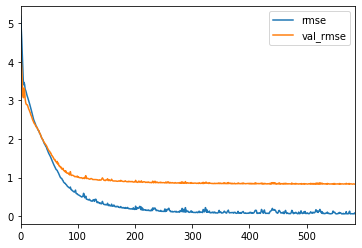

In [8]:
pd.DataFrame(performance.history)[['rmse', 'val_rmse']].plot()

In [9]:
pd.DataFrame(results).test_rmse.mean()

0.9936884638624601

In [10]:
pd.DataFrame(results).test_rmse.std()

0.0402222277854779

In [11]:
pd.DataFrame(results)

,task_name,train_rmse,valid_rmse,test_rmse,train_r2,valid_r2,test_r2,# trainable params,best_epoch,batch_size,lr,weight_decay
0,FreeSolv,0.121519,0.796980,0.986100,0.999718,0.945818,0.963010,803681,426,128,0.0001,0
1,FreeSolv,0.084998,0.792099,0.957801,0.999666,0.944350,0.962115,803681,420,128,0.0001,0
2,FreeSolv,0.077598,0.828495,1.037164,0.999744,0.940331,0.954958,803681,535,128,0.0001,0


In [12]:
pd.DataFrame(results).to_csv('./results/%s.csv' % task_name)